Here we perform a check on DE dataset to confirm choice of loss function for our data.


In [1]:
import os
import pandas as pd
import subprocess
import shutil
from utils.helper import extract_metrics_from_output, convert_results_into_df
from utils.error_analysis import plot_error_results

# 1. Informer results

In [17]:
# Paths to files and data
data_path = os.getcwd() + "/datasets/"

script_path = "./PatchTST-main/PatchTST_supervised/run_longExp.py"

# Arguments that will be used also for file names
model = "Informer"
dataset = 'DE_data.csv'
losses = ["MSE", "RMSE", "MAE"]
country = dataset[:2]

log_dir = f"logs/loss_choice"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_file_path = f"{log_dir}/{model}_{country}.log"

In [18]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "96"
lr = "0.0001"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Lists to store the results
informer_results_scaled, informer_results_unscaled = [], []

# Log file
with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to .ipynb output cell

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Arguments for the command
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --inverse \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()
            
            # Delete the checkpoints folder and all its contents
            shutil.rmtree('./checkpoints' )

            # Extract metrics for each iteration
            iteration_metrics = extract_metrics_from_output(output, itr)
            iteration_metrics_unscaled = extract_metrics_from_output(output, itr, if_scaled=False)

            # Log the extracted metrics and save them
            for iteration, (scaled_metrics, unscaled_metrics) in enumerate(zip(iteration_metrics, iteration_metrics_unscaled), start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"Scaled Metrics - MSE: {scaled_metrics[0]}, RMSE: {scaled_metrics[1]}, MAE: {scaled_metrics[2]}, RSE: {scaled_metrics[3]}\n")
                log_file.write(f"Unscaled Metrics - MSE: {unscaled_metrics[0]}, RMSE: {unscaled_metrics[1]}, MAE: {unscaled_metrics[2]}, RSE: {unscaled_metrics[3]}\n")

                # Append the results to the informer_results lists
                metrics_data = [(informer_results_scaled, scaled_metrics), (informer_results_unscaled, unscaled_metrics)]

                for result_list, metrics in metrics_data:
                    result_list.append({
                        'Loss_function': loss,
                        'Pred_len': pred_len,
                        'Iteration': iteration,
                        'MSE': metrics[0],
                        'RMSE': metrics[1],
                        'MAE': metrics[2],
                        'RSE': metrics[3]
                    })


=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_96_24_loss_choice_for_DE', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=96, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, us

In [20]:
path_dir = './dataset_results'
csv_name_scaled = 'informer_loss_functions_results_scaled.csv'
csv_name_unscaled = 'informer_loss_functions_results_unscaled.csv'

# Convert the results into a DataFrame and save as CSV
informer_df_scaled = convert_results_into_df(informer_results_scaled, path_dir, csv_name_scaled)
informer_df_unscaled = convert_results_into_df(informer_results_unscaled, path_dir, csv_name_unscaled)
informer_df_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.5078  0.7126  0.4996  0.5640
              2         24        0.4878  0.6985  0.4790  0.5528
              1         96        0.8278  0.9098  0.6768  0.7216
              2         96        0.8712  0.9334  0.6843  0.7403
              1         168       0.9250  0.9618  0.7023  0.7619
              2         168       0.8726  0.9341  0.6942  0.7400
RMSE          1         24        0.5071  0.7121  0.4983  0.5636
              2         24        0.4826  0.6947  0.4776  0.5498
              1         96        0.8019  0.8955  0.6663  0.7102
              2         96        0.8538  0.9240  0.6723  0.7329
              1         168       0.8935  0.9452  0.6883  0.7488
              2         168       0.9231  0.9608  0.6903  0.7611
MAE           1         24        0.4949  0.7035  0.4628  0.5568
              2         24        0.4903  0.7002  0.4557  0.5542
              1         96        0.9520  0.9757  0.6667  0.7739
              2         96        0.8675  0.9314  0.6356  0.7387
              1         168       0.9182  0.9582  0.6792  0.7591
              2         168       0.9472  0.9732  0.6660  0.7710

In [21]:
informer_df_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        20262616.0  4501.4014  3016.6672  0.2238
              2         24        19436216.0  4408.6523  2875.5586  0.2192
              1         96        35706256.0  5975.4712  4163.1543  0.2976
              2         96        38053568.0  6168.7573  4203.2881  0.3072
              1         168       41039112.0  6406.1777  4328.8550  0.3192
              2         168       37693112.0  6139.4717  4274.0054  0.3059
RMSE          1         24        20156686.0  4489.6196  2999.1426  0.2232
              2         24        19259186.0  4388.5288  2873.7637  0.2182
              1         96        34543984.0  5877.4131  4100.0752  0.2927
              2         96        36986492.0  6081.6519  4114.8584  0.3029
              1         168       38815100.0  6230.1768  4220.9731  0.3104
              2         168       40210260.0  6341.1562  4216.4253  0.3159
MAE           1         24        19648216.0  4432.6309  2762.4336  0.2204
              2         24        19207616.0  4382.6494  2741.9597  0.2179
              1         96        41247308.0  6422.4067  4063.6636  0.3198
              2         96        37667352.0  6137.3735  3862.1619  0.3056
              1         168       39692484.0  6300.1973  4161.8623  0.3139
              2         168       40591140.0  6371.1177  4053.1790  0.3174

In [46]:
# Uncomment the following lines if you want to read saved results
#path_dir = './dataset_results'
#csv_name_scaled = 'informer_loss_functions_results_scaled.csv'
#csv_name_unscaled = 'informer_loss_functions_results_unscaled.csv'

# Average the iterations
informer_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
informer_unscaled = pd.read_csv(os.path.join(path_dir, csv_name_unscaled))

inf_res_scaled = informer_scaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
inf_res_unscaled = informer_unscaled.groupby(['Pred_len', 'Loss_function']).mean().sort_index().drop('Iteration', axis=1)
inf_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Pred_len Loss_function                                
24       MAE            0.4926  0.7018  0.4592  0.5555
         MSE            0.4978  0.7055  0.4893  0.5584
         RMSE           0.4949  0.7034  0.4879  0.5567
96       MAE            0.9098  0.9536  0.6512  0.7563
         MSE            0.8495  0.9216  0.6805  0.7309
         RMSE           0.8278  0.9097  0.6693  0.7215
168      MAE            0.9327  0.9657  0.6726  0.7650
         MSE            0.8988  0.9479  0.6982  0.7509
         RMSE           0.9083  0.9530  0.6893  0.7550

In [47]:
inf_res_unscaled.round(4)

MSE       RMSE        MAE     RSE
Pred_len Loss_function                                          
24       MAE            19427916.0  4407.6401  2752.1967  0.2192
         MSE            19849416.0  4455.0269  2946.1129  0.2215
         RMSE           19707936.0  4439.0742  2936.4531  0.2207
96       MAE            39457330.0  6279.8901  3962.9127  0.3127
         MSE            36879912.0  6072.1143  4183.2212  0.3024
         RMSE           35765238.0  5979.5325  4107.4668  0.2978
168      MAE            40141812.0  6335.6575  4107.5206  0.3157
         MSE            39366112.0  6272.8247  4301.4302  0.3125
         RMSE           39512680.0  6285.6665  4218.6992  0.3132

In [ ]:
# Pred_len index was stored as a string, convert it to int
#inf_res_scaled.index = inf_res_scaled.index.set_levels([inf_res_scaled.index.levels[0].astype(int), inf_res_scaled.index.levels[1]])
#inf_res_scaled.sort_index(inplace=True)

# 2. PatchTST results

In [51]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "512"
lr = "0.0001"
model = "PatchTST"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# New log file path
log_file_path = f"{log_dir}/{model}_{country}.log"

patchtst_results_scaled, patchtst_results_unscaled = [], []

with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to notebook

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Command arguments
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --inverse \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Delete the checkpoints folder and all its contents
            shutil.rmtree('./checkpoints' )

            # Extract metrics for each iteration
            iteration_metrics_scaled = extract_metrics_from_output(output, itr)
            iteration_metrics_unscaled = extract_metrics_from_output(output, itr, if_scaled=False)

            # Log the extracted metrics and save them
            for iteration, (scaled_metrics, unscaled_metrics) in enumerate(zip(iteration_metrics_scaled, iteration_metrics_unscaled), start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"Scaled Metrics - MSE: {scaled_metrics[0]}, RMSE: {scaled_metrics[1]}, MAE: {scaled_metrics[2]}, RSE: {scaled_metrics[3]}\n")
                log_file.write(f"Unscaled Metrics - MSE: {unscaled_metrics[0]}, RMSE: {unscaled_metrics[1]}, MAE: {unscaled_metrics[2]}, RSE: {unscaled_metrics[3]}\n")

                # Append the results to the informer_results lists
                metrics_data = [(patchtst_results_scaled, scaled_metrics), (patchtst_results_unscaled, unscaled_metrics)]

                for result_list, metrics in metrics_data:
                    result_list.append({
                        'Loss_function': loss,
                        'Pred_len': pred_len,
                        'Iteration': iteration,
                        'MSE': metrics[0],
                        'RMSE': metrics[1],
                        'MAE': metrics[2],
                        'RSE': metrics[3]
                    })


=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_512_24_loss_choice_for_DE', model='PatchTST', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=512, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, 

In [151]:
path_dir = './dataset_results'
csv_name_scaled = 'patchtst_loss_functions_results_scaled.csv'
csv_name_unscaled = 'patchtst_loss_functions_results_unscaled.csv'


# Convert the results into a DataFrame and save as CSV
patchtst_df_scaled = convert_results_into_df(patchtst_results_scaled, path_dir, csv_name_scaled)
patchtst_df_unscaled = convert_results_into_df(patchtst_results_unscaled, path_dir, csv_name_unscaled)
patchtst_df_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.4551  0.6746  0.4416  0.5339
              2         24        0.4664  0.6829  0.4506  0.5405
              1         96        0.7439  0.8625  0.6113  0.6841
              2         96        0.7726  0.8790  0.6245  0.6971
              1         168       0.8226  0.9070  0.6497  0.7185
              2         168       0.8047  0.8970  0.6460  0.7106
RMSE          1         24        0.4513  0.6718  0.4435  0.5317
              2         24        0.4518  0.6722  0.4493  0.5320
              1         96        0.7535  0.8680  0.6172  0.6884
              2         96        0.7755  0.8806  0.6255  0.6985
              1         168       0.8276  0.9097  0.6519  0.7207
              2         168       0.8039  0.8966  0.6451  0.7103
MAE           1         24        0.4612  0.6791  0.4230  0.5375
              2         24        0.4455  0.6674  0.4187  0.5282
              1         96        0.7656  0.8750  0.5963  0.6940
              2         96        0.8202  0.9057  0.6112  0.7183
              1         168       0.8244  0.9080  0.6256  0.7193
              2         168       0.8161  0.9034  0.6275  0.7156

In [152]:
patchtst_df_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        17261680.0  4154.7178  2581.1782  0.2066
              2         24        17762658.0  4214.5767  2639.2039  0.2096
              1         96        30875704.0  5556.5908  3633.8970  0.2767
              2         96        32792920.0  5726.5103  3746.3784  0.2852
              1         168       35247892.0  5936.9937  3905.6101  0.2958
              2         168       34226872.0  5850.3735  3899.1096  0.2915
RMSE          1         24        17305828.0  4160.0273  2609.1721  0.2068
              2         24        17345650.0  4164.8110  2657.5583  0.2071
              1         96        31262294.0  5591.2695  3673.3840  0.2784
              2         96        33044252.0  5748.4131  3757.2954  0.2863
              1         168       35287100.0  5940.2944  3912.6470  0.2960
              2         168       34170808.0  5845.5801  3891.9578  0.2913
MAE           1         24        17183404.0  4145.2871  2456.1895  0.2061
              2         24        16678795.0  4083.9680  2431.3040  0.2031
              1         96        31555720.0  5617.4478  3527.8032  0.2798
              2         96        34537172.0  5876.8335  3631.9407  0.2927
              1         168       35018344.0  5917.6299  3745.1887  0.2948
              2         168       33935912.0  5825.4536  3740.7778  0.2903

In [153]:
# Uncomment the following lines if you want to read saved results
#path_dir = './dataset_results'
#csv_name_scaled = 'patchtst_loss_functions_results_scaled.csv'
#csv_name_unscaled = 'patchtst_loss_functions_results_unscaled.csv'

# Average the iterations
ptst_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
ptst_unscaled = pd.read_csv(os.path.join(path_dir, csv_name_unscaled))

ptst_res_scaled = ptst_scaled.groupby(['Loss_function', 'Pred_len']).mean().drop('Iteration', axis=1)
ptst_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Pred_len                                
MAE           24        0.4534  0.6733  0.4208  0.5329
              96        0.7929  0.8903  0.6038  0.7061
              168       0.8203  0.9057  0.6265  0.7175
MSE           24        0.4608  0.6788  0.4461  0.5372
              96        0.7583  0.8708  0.6179  0.6906
              168       0.8137  0.9020  0.6478  0.7146
RMSE          24        0.4515  0.6720  0.4464  0.5318
              96        0.7645  0.8743  0.6214  0.6935
              168       0.8158  0.9032  0.6485  0.7155

In [154]:
ptst_res_unscaled = ptst_unscaled.groupby(['Loss_function', 'Pred_len']).mean().drop('Iteration', axis=1)
ptst_res_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Pred_len                                          
MAE           24        16931099.5  4114.6276  2443.7467  0.2046
              96        33046446.0  5747.1406  3579.8719  0.2862
              168       34477128.0  5871.5417  3742.9833  0.2925
MSE           24        17512169.0  4184.6472  2610.1910  0.2081
              96        31834312.0  5641.5505  3690.1377  0.2810
              168       34737382.0  5893.6836  3902.3599  0.2937
RMSE          24        17325739.0  4162.4192  2633.3652  0.2070
              96        32153273.0  5669.8413  3715.3397  0.2824
              168       34728954.0  5892.9373  3902.3024  0.2936

# 3. Plot Informer errors

We plot unscaled data for each column.

The more the line is narrow and corresponds to the 45 degree line - the better.


Dark spots mean more observations.


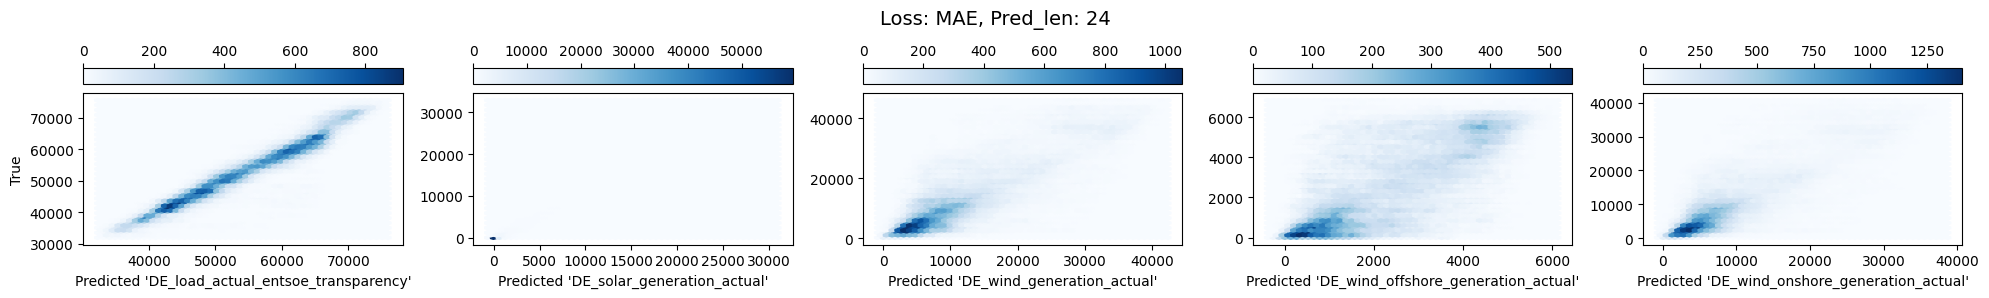

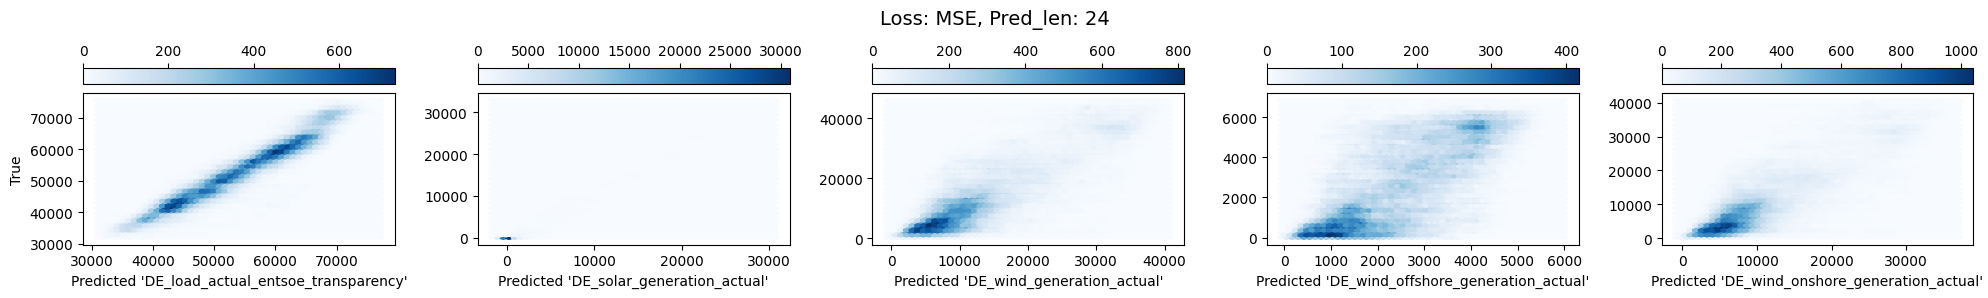

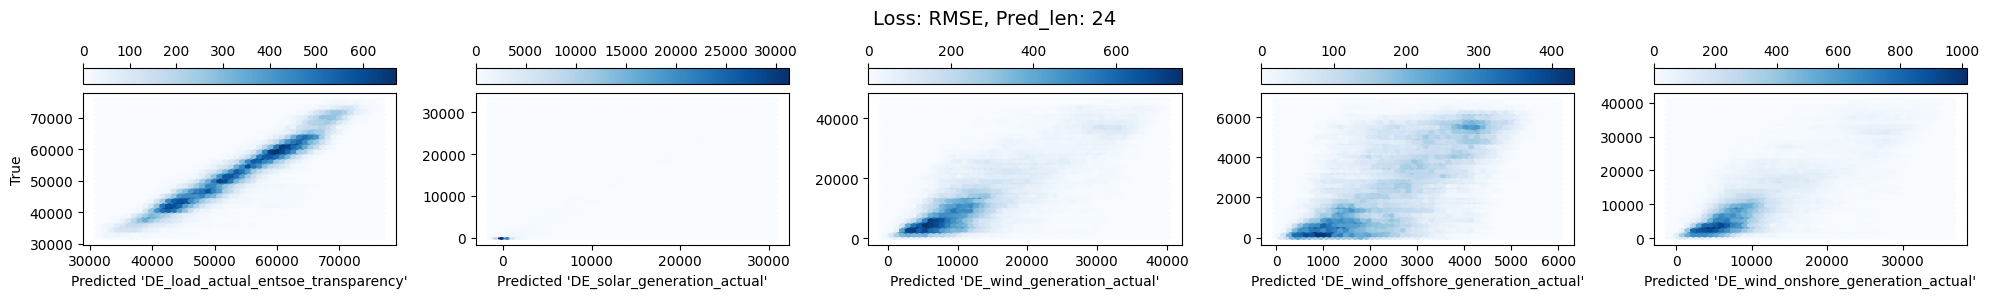

----------------------------------------------------------------------------------------------------------------------------------------------------------------


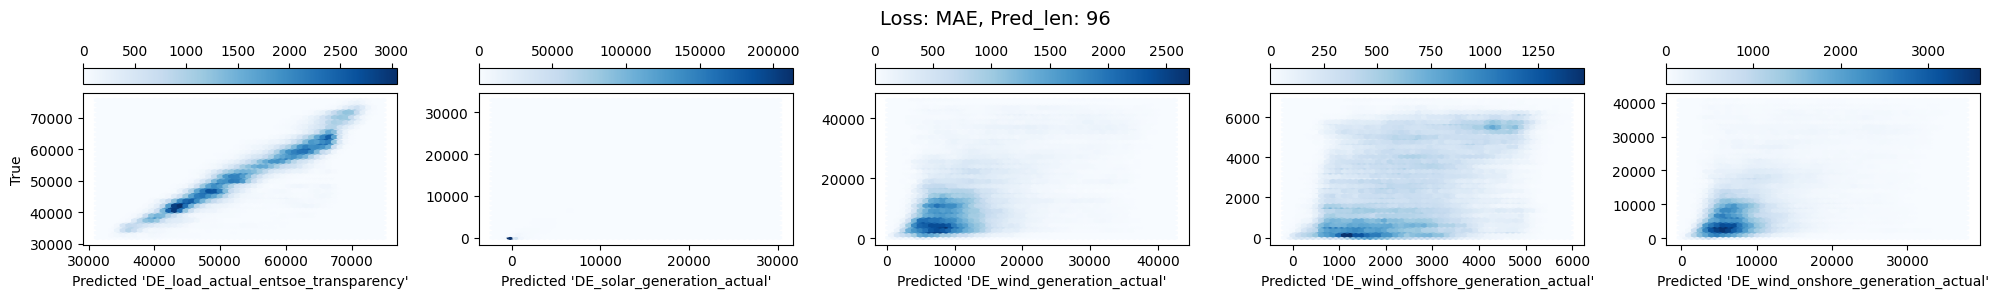

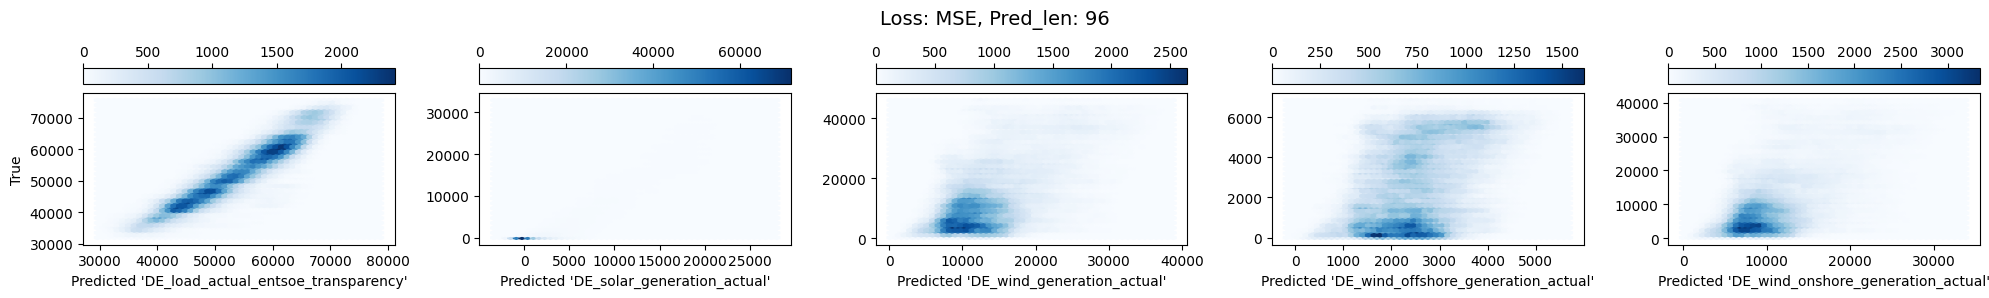

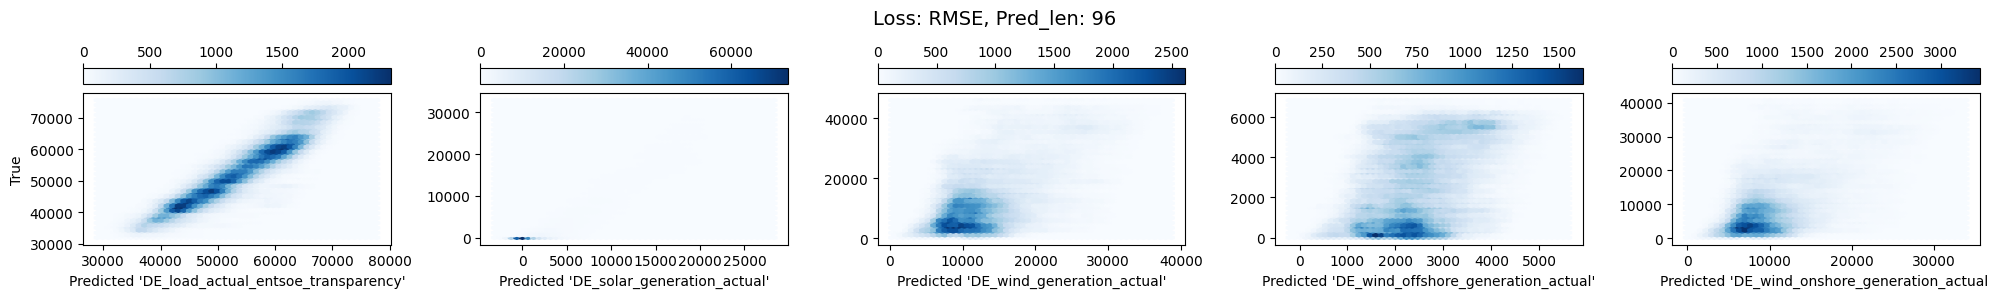

----------------------------------------------------------------------------------------------------------------------------------------------------------------


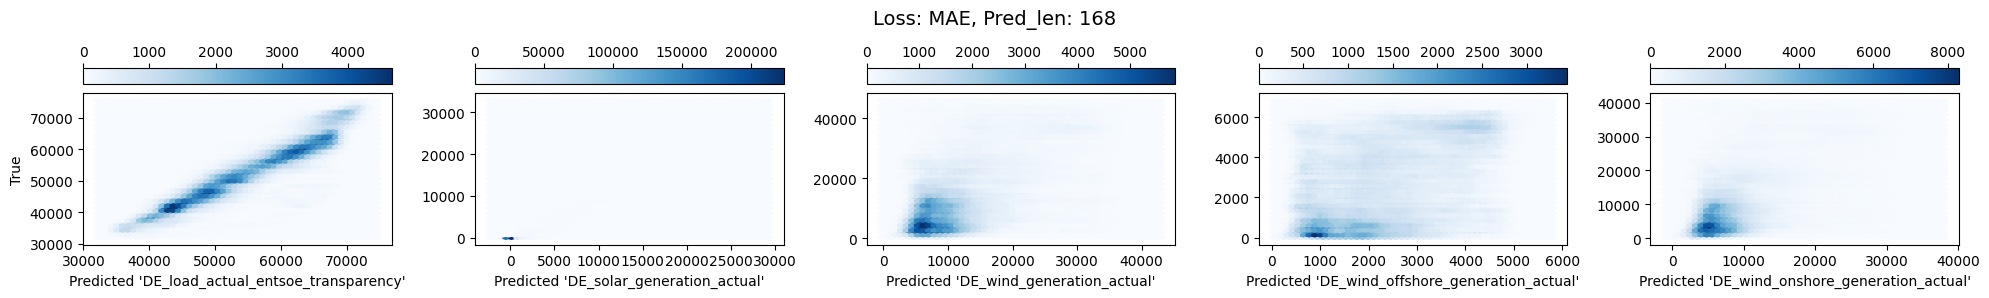

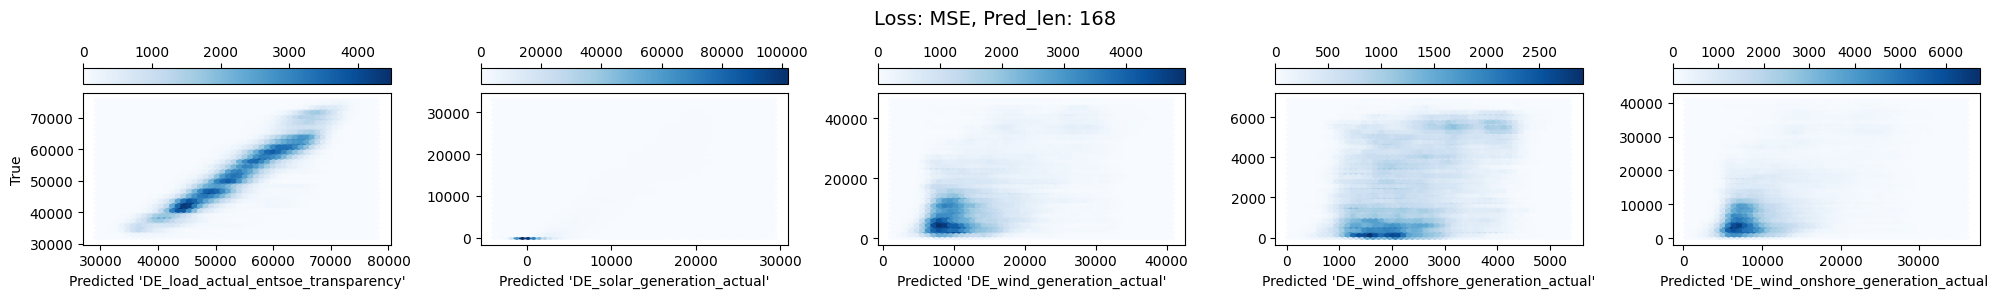

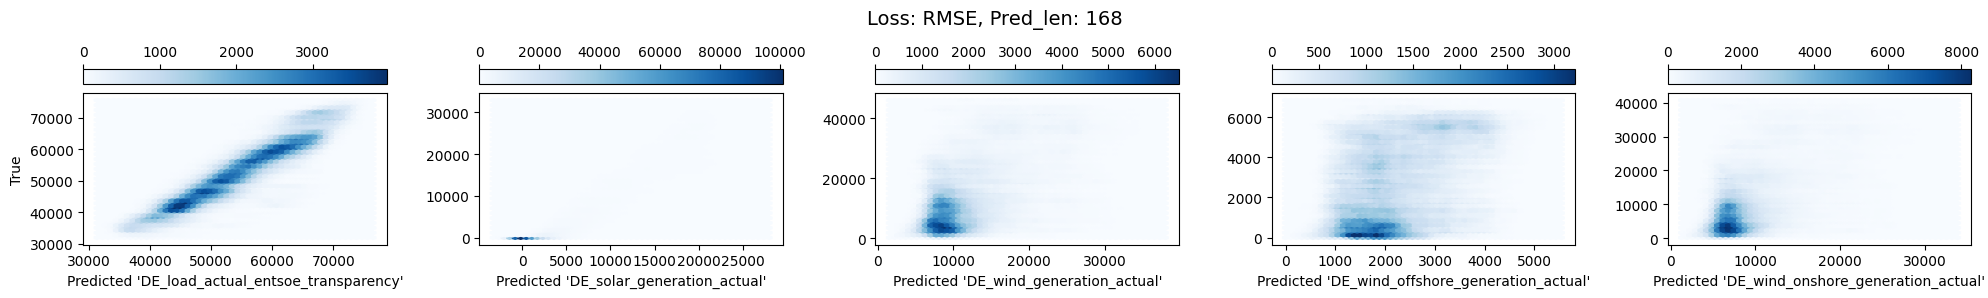

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [2]:
# Extract columns
cols = pd.read_csv("datasets/DE_data.csv").columns[1:]

#color_maps = ["Blues", "Oranges", "Greens"]
color_maps = ["Blues"]*3 # So easier to compare

# Plots
for pred_len in [24, 96, 168]:
    for i, loss in enumerate(["MAE", "MSE", "RMSE"]):
        plot_error_results("Informer", loss, seq_len=96, pred_len=pred_len, itr=2, columns=cols, color=color_maps[i])
    print("-"*160)


# 4. Plot PatchTST errors

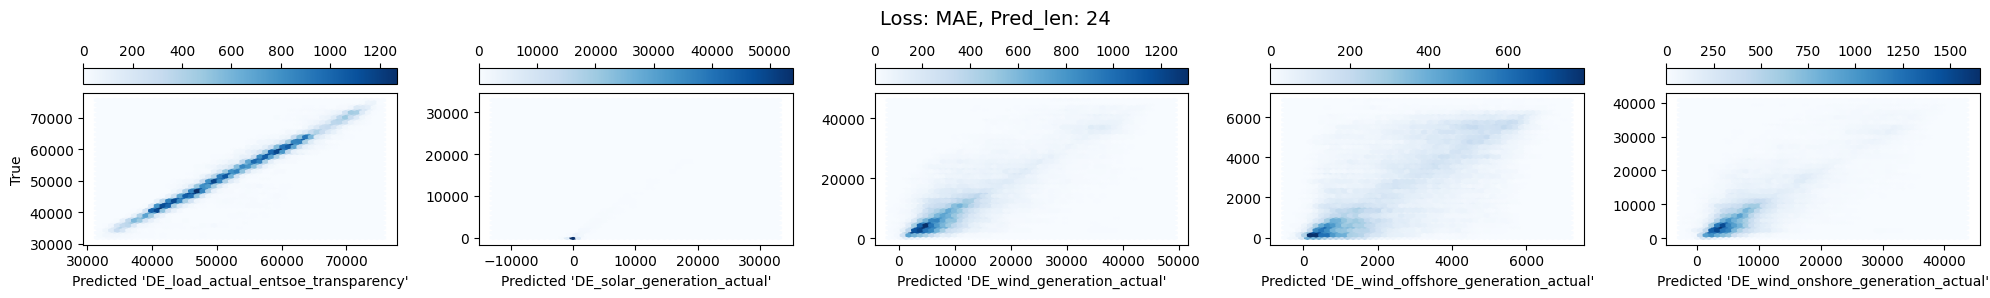

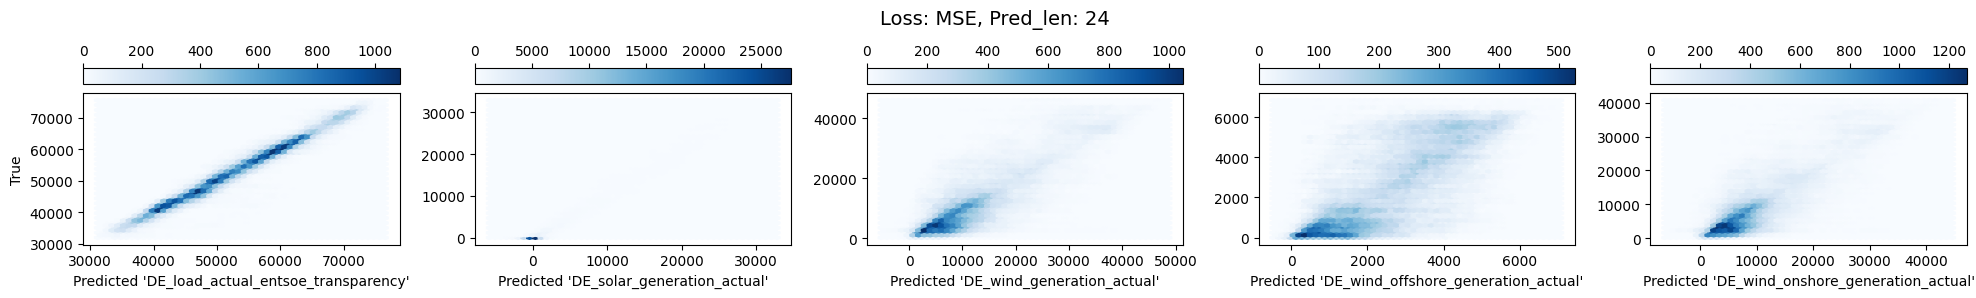

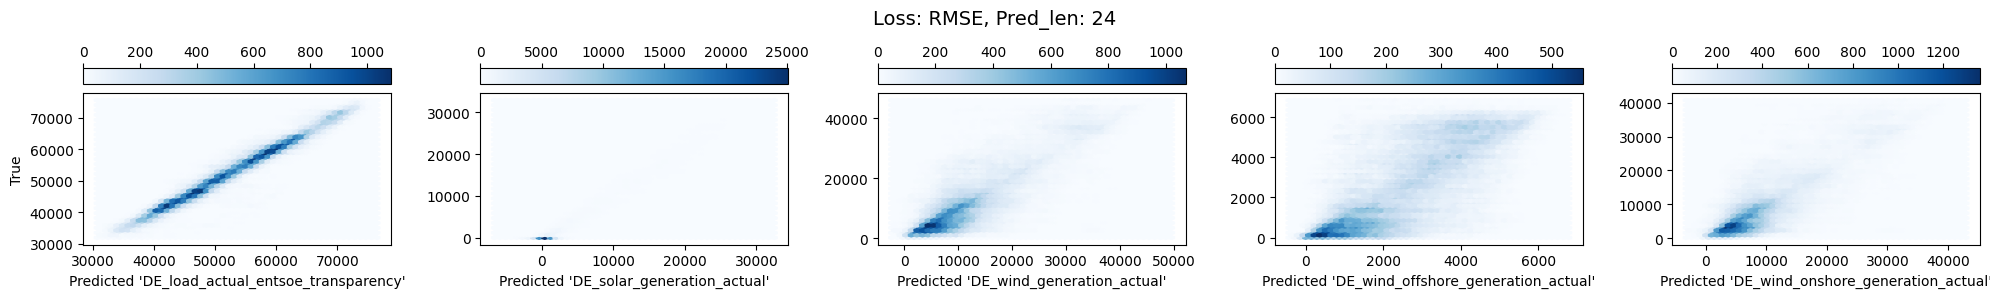

----------------------------------------------------------------------------------------------------------------------------------------------------------------


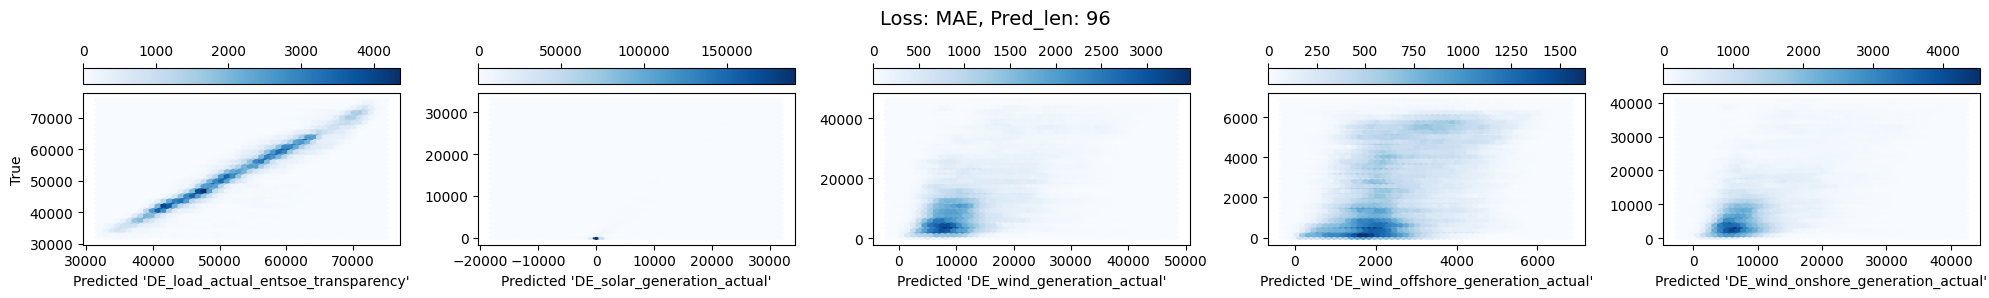

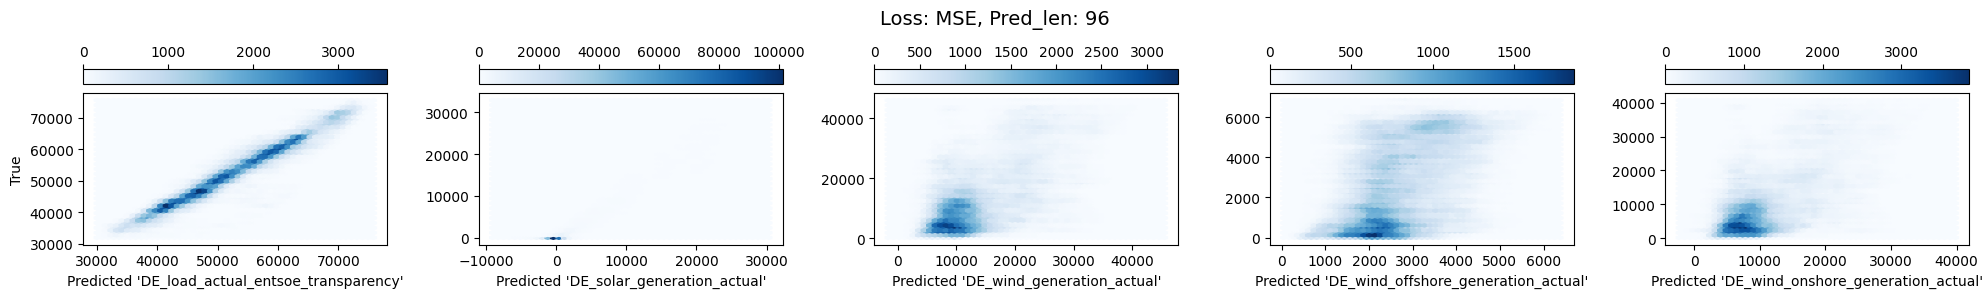

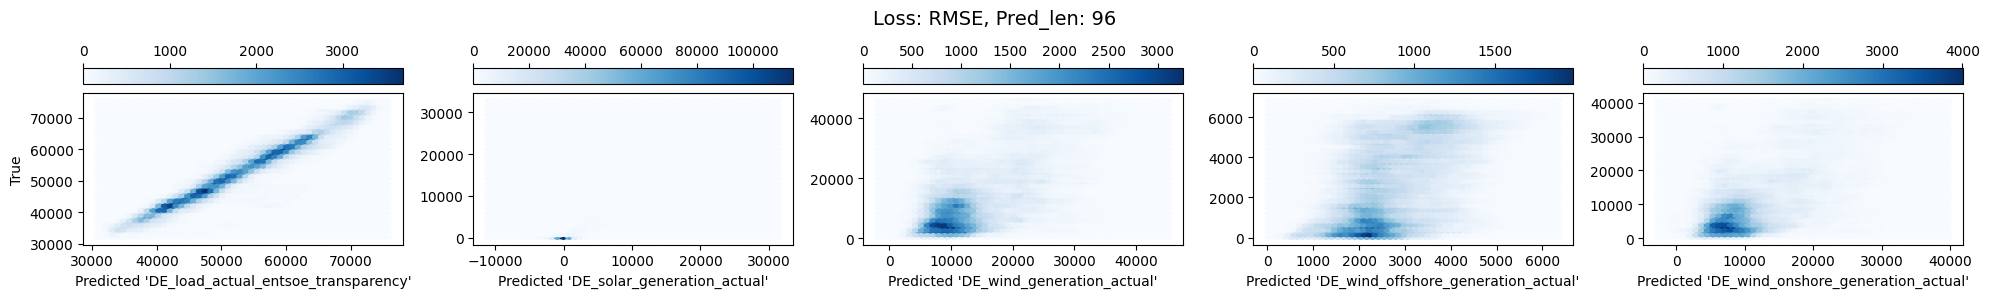

----------------------------------------------------------------------------------------------------------------------------------------------------------------


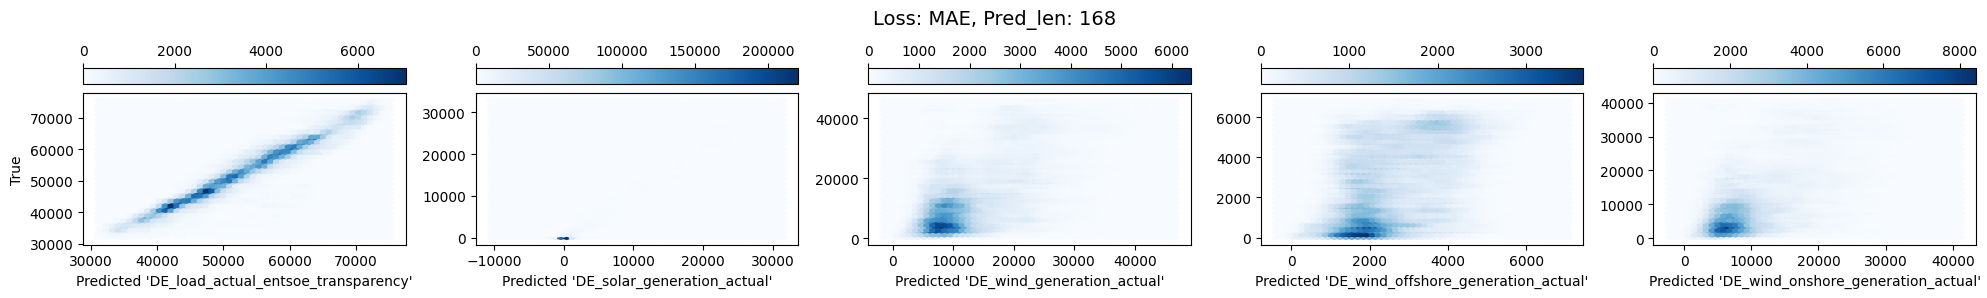

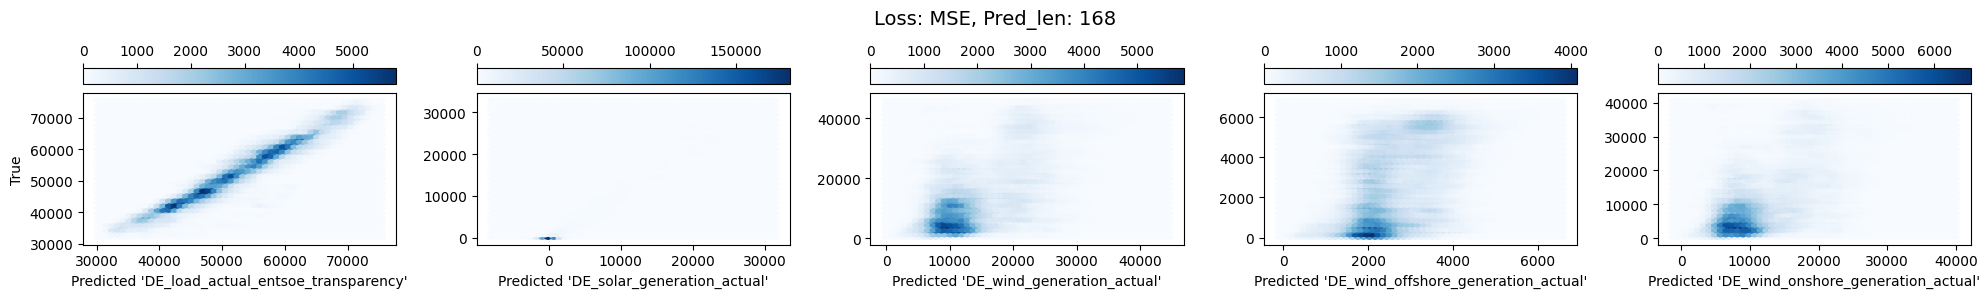

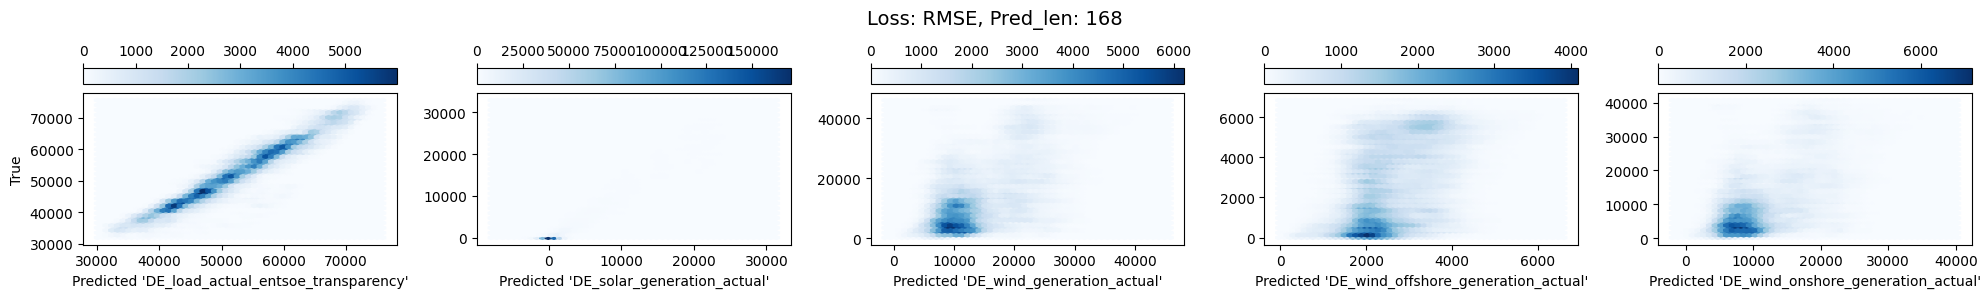

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [3]:
# Extract columns
cols = pd.read_csv("datasets/DE_data.csv").columns[1:]

#color_maps = ["Blues", "Oranges", "Greens"]
color_maps = ["Blues"]*3 # So easier to compare

# Plots
for pred_len in [24, 96, 168]:
    for i, loss in enumerate(["MAE", "MSE", "RMSE"]):
        plot_error_results("PatchTST", loss, seq_len=512, pred_len=pred_len, itr=2, columns=cols, color=color_maps[i])
    print("-"*160)